In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import kpss
import statsmodels.tsa.stattools as tsa
from pmdarima import auto_arima

In [93]:
import warnings # Desactivar todas las advertencias
warnings.filterwarnings("ignore")

In [94]:
fact_full = pd.read_excel('.\Data\Descarga_FACTURADO_CLIENTES_NB_240823.xlsx',skiprows=1)
df_fact = fact_full.groupby(by = 'Periodo', sort = True)['Suma Total'].sum().reset_index()
df_fact.rename(columns={'Periodo': 'mes', 'Suma Total': 'fact'}, inplace = True)
df_fact.set_index('mes', inplace = True)
df_fact.head()

,fact
mes,
2019-01-01,22150781.76
2019-02-01,20681481.53
2019-03-01,22316953.30
2019-04-01,22943028.41
2019-05-01,22975503.75


In [95]:
vent_full = pd.read_excel('.\Data\Descarga_VENTAS_POR_LOCALES_NB_050923.xlsx',skiprows=1)
df_vent = vent_full.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_vent.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_vent.mes = pd.to_datetime(df_vent.mes, dayfirst = True, format = '%m/%Y')
df_vent = df_vent.sort_values(by = 'mes')
df_vent.set_index('mes', inplace = True)
df_vent.head()

,ventas
mes,
2015-01-01,62633592.89
2015-02-01,62563213.35
2015-03-01,70487376.77
2015-04-01,68644186.80
2015-05-01,70835132.46


In [96]:
df_ipc = pd.read_excel('.\Data\Tabla_IPC.xlsx',skiprows=1)
df_ipc.rename(columns={'Fecha': 'fecha', 'Indice': 'ipc'}, inplace = True)
df_ipc.set_index('fecha', inplace=True)
df_ipc.head()

,ipc
fecha,
2016-12-01,100.0000
2017-01-01,101.5859
2017-02-01,103.6859
2017-03-01,106.1476
2017-04-01,108.9667


In [97]:
df_usd = pd.read_excel('.\Data\Dolar_Evolución.xlsx',skiprows=0)
df_usd = df_usd.iloc[:, 1:]
df_usd.columns = ['fecha', 'ofi', 'blue']
df_usd.set_index('fecha', inplace=True)
df_usd.head()

,ofi,blue
fecha,,
2015-01-01,8.55,13.50
2015-02-01,8.63,12.93
2015-03-01,8.72,12.52
2015-04-01,8.81,12.60
2015-05-01,8.90,12.55


In [98]:
df_retail = vent_full[(vent_full['Razón Social'] != 'GD WORK SA') & (vent_full['Rubro'] != 'SUPERMERCADO')]
df_retail = df_retail.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_retail.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_retail.mes = pd.to_datetime(df_retail.mes, dayfirst = True, format = '%m/%Y')
df_retail = df_retail.sort_values(by = 'mes')
df_retail.set_index('mes', inplace = True)
df_retail.head()

,ventas
mes,
2015-01-01,35881254.22
2015-02-01,35994300.23
2015-03-01,41635908.20
2015-04-01,41074614.00
2015-05-01,43747283.60


In [99]:
df_super = vent_full[vent_full['Rubro'] == 'SUPERMERCADO']
df_super = df_super.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_super.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_super.mes = pd.to_datetime(df_super.mes, dayfirst = True, format = '%m/%Y')
df_super = df_super.sort_values(by = 'mes')
df_super.set_index('mes', inplace = True)
df_super.head()

,ventas
mes,
2015-01-01,26752338.67
2015-02-01,26568913.12
2015-03-01,28851468.57
2015-04-01,27569572.80
2015-05-01,27087848.86


In [100]:
df_cowork = vent_full[vent_full['Razón Social'] == 'GD WORK SA']
df_cowork = df_cowork.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_cowork.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_cowork.mes = pd.to_datetime(df_cowork.mes, dayfirst = True, format = '%m/%Y')
df_cowork = df_cowork.sort_values(by = 'mes')
df_cowork.set_index('mes', inplace = True)
df_cowork.head()

,ventas
mes,
2019-01-01,824754.21
2019-02-01,983820.43
2019-03-01,1281202.80
2019-04-01,2000058.99
2019-05-01,1787994.13


In [101]:
#df_ipc.reset_index(inplace=True)
df_ipc['ipc_previo'] = df_ipc['ipc'].shift(1)
df_ipc['ipc_intermensual'] = (df_ipc['ipc'] - df_ipc['ipc_previo']) / df_ipc['ipc']
#df_ipc.set_index

In [102]:

def filtrar_serie(serie, start_date, end_date):
    serie = serie[(serie.index >= start_date) & (serie.index <= end_date)]
    return serie

In [103]:
df_vent = filtrar_serie(df_vent, '2017-01-01', '2023-08-01')
df_retail = filtrar_serie(df_retail, '2017-01-01', '2023-08-01')
df_cowork = filtrar_serie(df_cowork, '2017-01-01', '2023-08-01')
df_super = filtrar_serie(df_super, '2017-01-01', '2023-08-01')
df_usd = filtrar_serie(df_usd, '2017-01-01', '2023-08-01')

In [104]:
def corregir_usd_ipc(serie, ipc, dolar):
    corregida = serie / (1 + ipc)
    corregida = corregida / dolar
    return corregida

In [105]:
df_vent['ventas_ajustado'] = corregir_usd_ipc(df_vent['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_cowork['ventas_ajustado'] = corregir_usd_ipc(df_cowork['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_retail['ventas_ajustado'] = corregir_usd_ipc(df_retail['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_super['ventas_ajustado'] = corregir_usd_ipc(df_super['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])

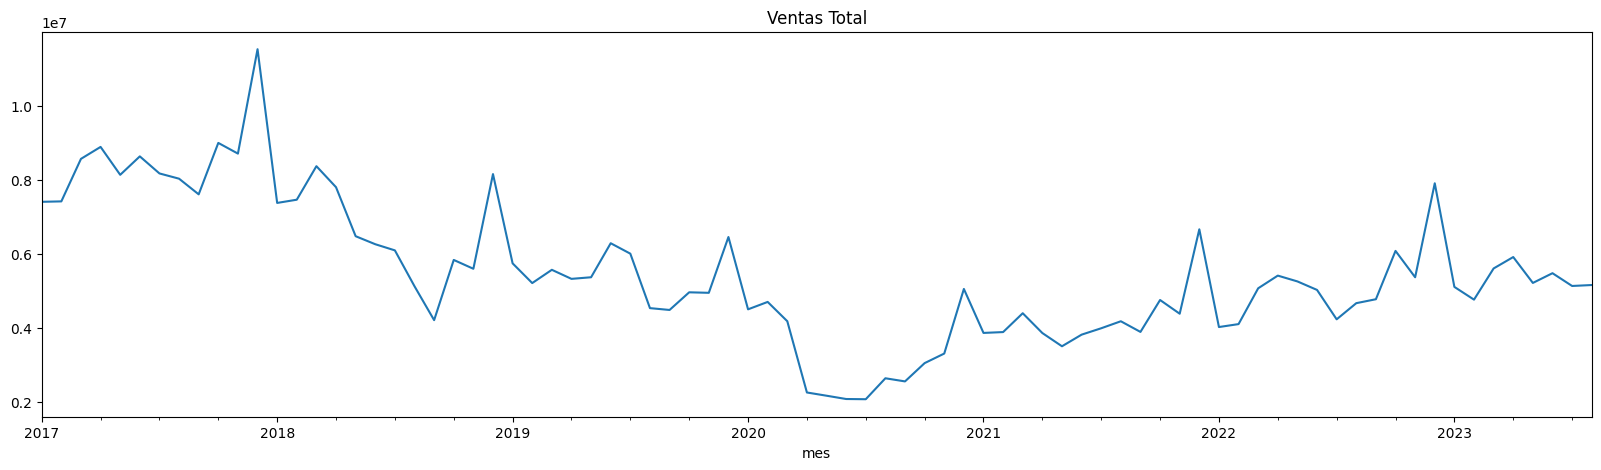

In [106]:
df_vent.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Total")
plt.show()

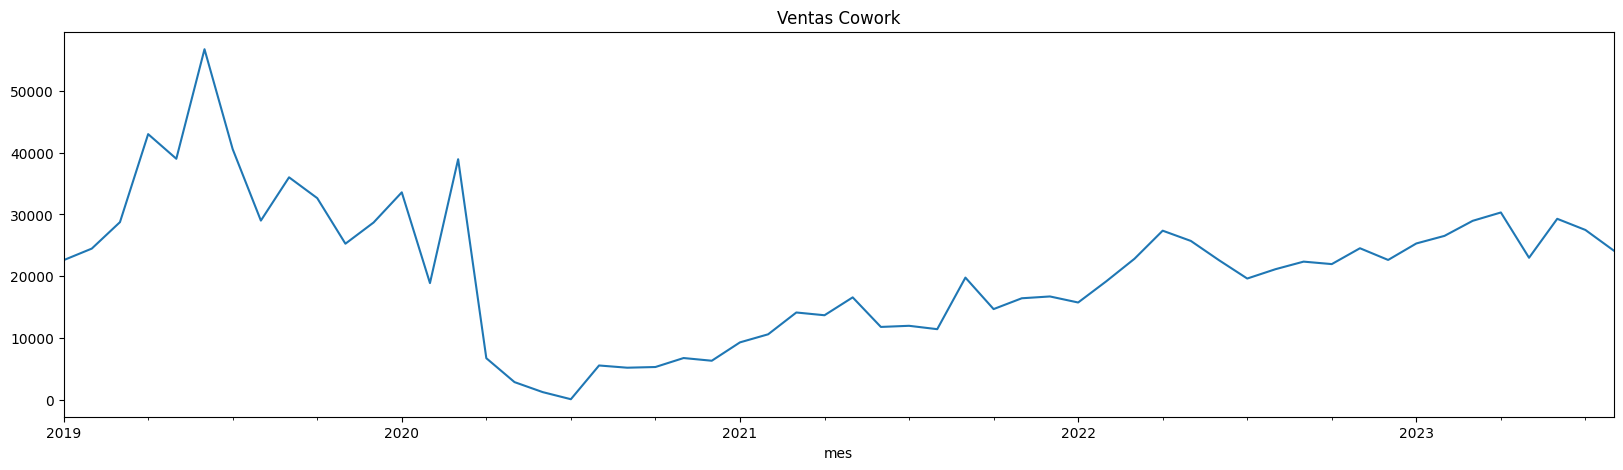

In [107]:
df_cowork.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Cowork")
plt.show()

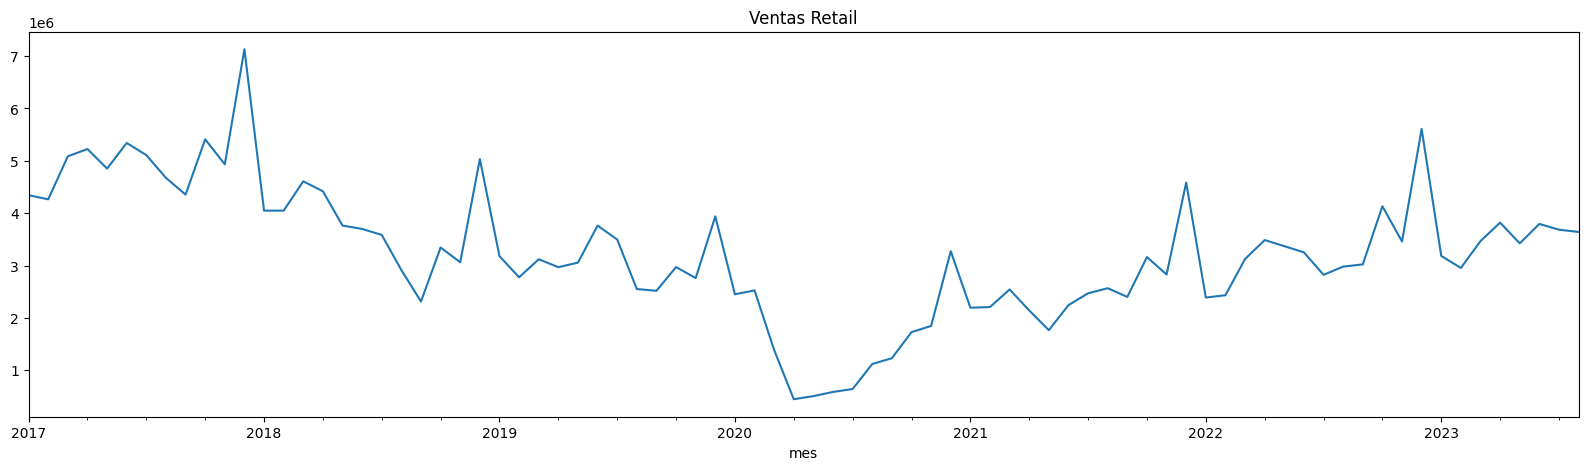

In [108]:
df_retail.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Retail")
plt.show()

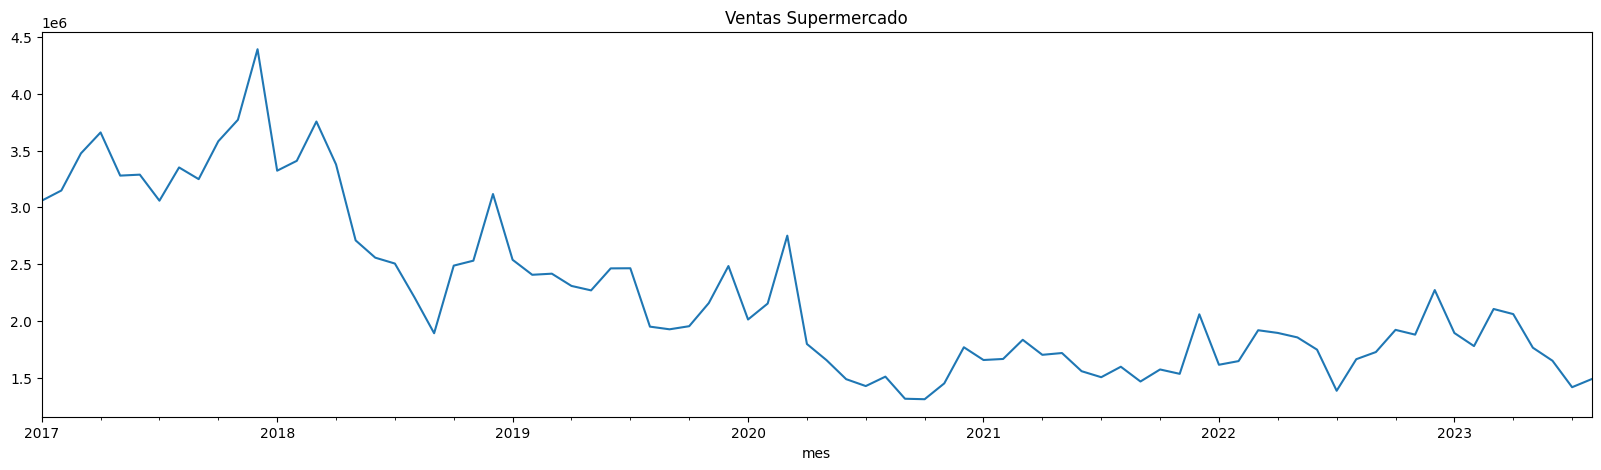

In [109]:
df_super.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Supermercado")
plt.show()

Arranca analisis

Inciso 2 -  Grafico de la serie original

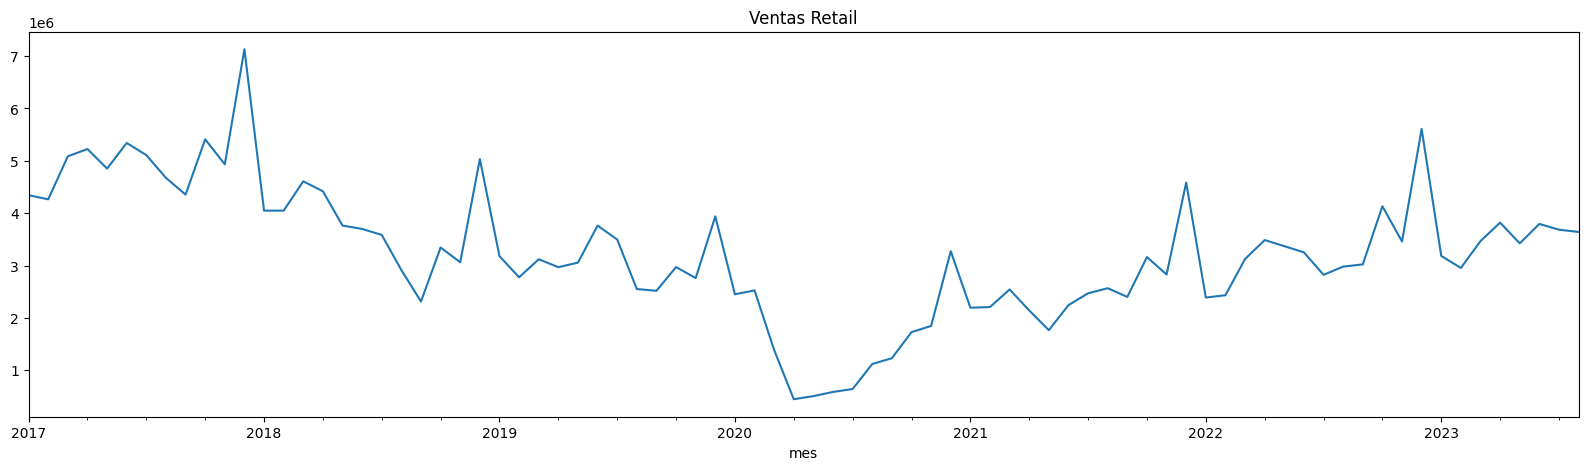

In [110]:
df_retail.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Retail")
plt.show()

a simple vista no es estacionaria

Inciso 3 - Funciones de ACF y PACF

In [111]:
df_retail['diff1'] = df_retail.ventas_ajustado.diff(periods = 1)
df_retail.diff1[0] = 0

In [112]:
## Función para dibujar juntos FAS: autocovarianzas; FAC (autocorrelacion ) y FACP (autocorrelación parcial)
def autocov_autocorr(serie_r,serie_nr, nrol= 75 ):
  p1, axes=plt.subplots(3,2,figsize=(18,10),sharex=True, sharey=False )
  axes[2,0].set_xlabel('Lag')
  axes[2,1].set_xlabel('Lag')

  plot_acf(serie_r, lags=nrol, ax= axes[0,0], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title=serie_r.name )
  plot_pacf(serie_r, lags=nrol, ax= axes[1,0], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,0].plot(tsa.acovf(serie_r,fft=False, nlag=nrol), color='r', label='AutoCov')

  plot_acf(serie_nr, lags=nrol, ax= axes[0,1], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title=serie_nr.name)
  plot_pacf(serie_nr, lags=nrol, ax= axes[1,1], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,1].plot(tsa.acovf(serie_nr,fft=False, nlag=nrol), color='r', label='AutoCov')

  p1.legend()
  plt.show()

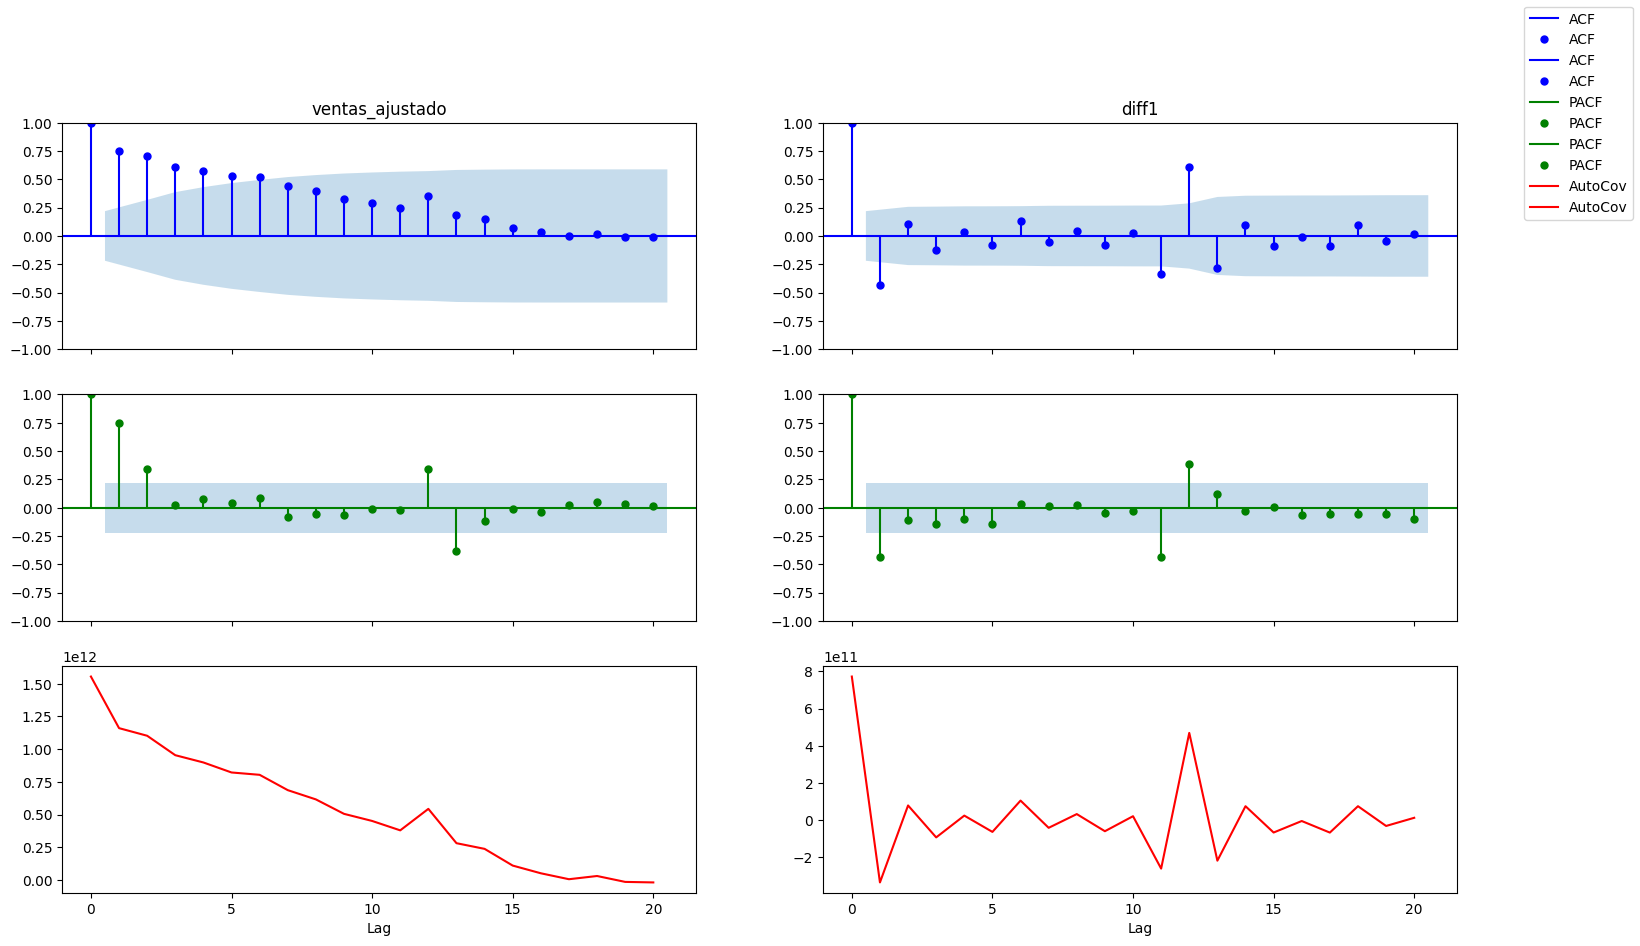

In [113]:
autocov_autocorr(df_retail.ventas_ajustado, df_retail.diff1, 20)

Inciso 4 - Pruebas de raices unitarias

In [114]:
def print_test_adf(y):
  resultado = adfuller(y, regression='c')
  print(f'Estadistico ADF: {resultado[0]:.4f} \t p-valor: {resultado[1]:.4f} Constante sola')
  resultado = adfuller(y, regression='ct')
  print(f'Estadistico ADF: {resultado[0]:.4f} \t p-valor: {resultado[1]:.4f} Constante y Tendencia Lineal')
  resultado = adfuller(y, regression='ctt')
  print(f'Estadistico ADF: {resultado[0]:.4f} \t p-valor: {resultado[1]:.4f} Constante y Tendencia Lineal y Cuadratica')
  resultado = adfuller(y, regression='n')
  print(f'Estadistico ADF: {resultado[0]:.4f} \t p-valor: {resultado[1]:.4f} Sin Contante ni Tendencia')


In [115]:
print_test_adf(df_retail.ventas_ajustado)

Estadistico ADF: -2.1134 	 p-valor: 0.2391 Constante sola
Estadistico ADF: -1.5532 	 p-valor: 0.8102 Constante y Tendencia Lineal
Estadistico ADF: -2.7274 	 p-valor: 0.4387 Constante y Tendencia Lineal y Cuadratica
Estadistico ADF: -0.7234 	 p-valor: 0.4027 Sin Contante ni Tendencia


In [116]:
from arch.unitroot import PhillipsPerron

In [117]:
def Phillips_Perron(series, **k):

    params = {'n':'No incluye término independiente ni lineal',
              'c':'Incluya término independiente pero no incluye término lineal',
              'ct':'Incluya ambos términos'
              }
    for param in params:
        print(f'Tipo de regresión: {param} - {params.get(param)}')
        pp = PhillipsPerron(series,trend=param, **k)
        print(f'PP Estadistico: {pp.stat}')
        print(f'p-valor: {pp.pvalue}')
        print(f'numero de lags: {pp.lags}')
        print('Valor Critico:')
        for key, value in pp.critical_values.items():
            print(f'   {key} : {value}')
        print(f'Resultado: La serie es {"no " if pp.pvalue > 0.05 else ""}estacionaria')
        print(f"PP Numero de diferenciacion estimada: {ndiffs(series, test='pp')}")

        print("*".center(60, '*'))
        print("")

In [118]:
Phillips_Perron(df_retail.ventas_ajustado)

Tipo de regresión: n - No incluye término independiente ni lineal
PP Estadistico: -0.8730458328385109
p-valor: 0.34000625755403735
numero de lags: 12
Valor Critico:
   1% : -2.5946224226886714
   5% : -1.9448758487665276
   10% : -1.6138413966846434
Resultado: La serie es no estacionaria
PP Numero de diferenciacion estimada: 1
************************************************************

Tipo de regresión: c - Incluya término independiente pero no incluye término lineal
PP Estadistico: -3.616186018442617
p-valor: 0.005459019683554174
numero de lags: 12
Valor Critico:
   1% : -3.5159766913976376
   5% : -2.898885703483903
   10% : -2.5866935058484217
Resultado: La serie es estacionaria
PP Numero de diferenciacion estimada: 1
************************************************************

Tipo de regresión: ct - Incluya ambos términos
PP Estadistico: -3.961294752155391
p-valor: 0.009973005152350809
numero de lags: 12
Valor Critico:
   1% : -4.078193339938625
   5% : -3.467604557671908
   1

In [119]:
def kpss_test(series, **kw):

    params = {'c':'Los datos son estacionarios alrededor de una constante.',
              'ct': 'Los datos son estacionarios alrededor de una tendencia.'
             }

    for param in params:
        print(f'Tipo de regresión: {param} - {params.get(param)}')

        statistic, p_value, n_lags, critical_values = kpss(series,regression = param, **kw)
        # Format Output
        print(f'KPSS Estadistico: {statistic}')
        print(f'p-valor: {p_value}')
        print(f'numero de lags: {n_lags}')
        print('Valor critico:')
        for key, value in critical_values.items():
            print(f'   {key} : {value}')
        print(f'Resultado: La serie es {"no " if p_value < 0.05 else ""}estacionaria')
        print(f"KPSS Numero estimado de diferencias a aplicar: {ndiffs(series, test='kpss')}")

        print("*".center(60, '*'))
        print("")

In [120]:
kpss_test(df_retail.ventas_ajustado)

Tipo de regresión: c - Los datos son estacionarios alrededor de una constante.
KPSS Estadistico: 0.4973259506360773
p-valor: 0.042268930036919526
numero de lags: 5
Valor critico:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Resultado: La serie es no estacionaria
KPSS Numero estimado de diferencias a aplicar: 1
************************************************************

Tipo de regresión: ct - Los datos son estacionarios alrededor de una tendencia.
KPSS Estadistico: 0.2969823601371599
p-valor: 0.01
numero de lags: 5
Valor critico:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Resultado: La serie es no estacionaria
KPSS Numero estimado de diferencias a aplicar: 1
************************************************************



Hasta ahora comprobamos que la serie original no es estacionaria

Pero los tests nos dan indicios de que la primer diferencia podria funcionar

arIma para todos

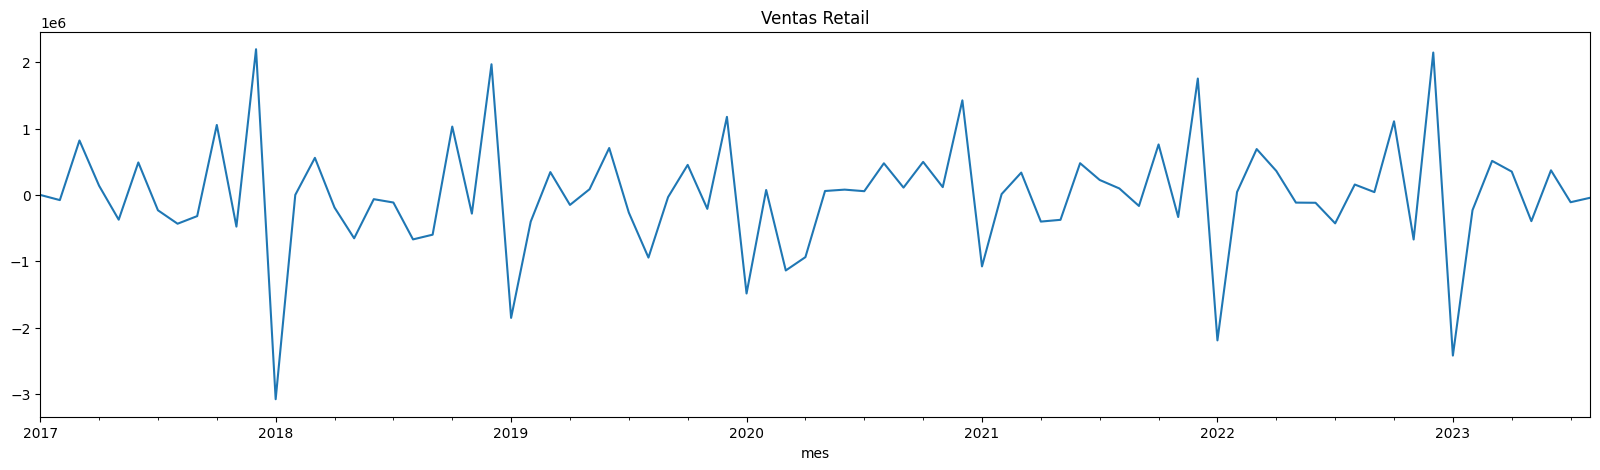

Estadistico ADF: -2.7607 	 p-valor: 0.0641 Constante sola
Estadistico ADF: -4.3799 	 p-valor: 0.0024 Constante y Tendencia Lineal
Estadistico ADF: -4.0866 	 p-valor: 0.0245 Constante y Tendencia Lineal y Cuadratica
Estadistico ADF: -2.6607 	 p-valor: 0.0076 Sin Contante ni Tendencia
Tipo de regresión: n - No incluye término independiente ni lineal
PP Estadistico: -18.042641384230386
p-valor: 5.0060673041025104e-29
numero de lags: 12
Valor Critico:
   1% : -2.5946224226886714
   5% : -1.9448758487665276
   10% : -1.6138413966846434
Resultado: La serie es estacionaria
PP Numero de diferenciacion estimada: 0
************************************************************

Tipo de regresión: c - Incluya término independiente pero no incluye término lineal
PP Estadistico: -17.993586851895877
p-valor: 2.749141302693277e-30
numero de lags: 12
Valor Critico:
   1% : -3.5159766913976376
   5% : -2.898885703483903
   10% : -2.5866935058484217
Resultado: La serie es estacionaria
PP Numero de diferen

In [121]:
df_retail.diff1.plot(figsize=(20,5), title = "Ventas Retail")
plt.show()

print_test_adf(df_retail.diff1)

Phillips_Perron(df_retail.diff1)

kpss_test(df_retail.diff1)


Inciso 5 - SARIMAX

In [122]:
sarimax = auto_arima(df_retail.ventas_ajustado,
                     start_p=1, max_p=12,
                     start_d=1, max_d=3,
                     start_q=1, max_q=12,
                     start_P=0, max_P=12,
                     start_D=0, max_D=12,
                     start_Q=0, max_Q=12,
           seasonal=True, m=7, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=2383.102, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2391.582, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2382.870, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2383.473, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2389.596, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2380.998, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=2382.877, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=2384.861, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=2383.069, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=2381.594, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=2385.158, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=2378.961, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7]             : AIC=2380.832, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1)[7]             : AIC=2380.837, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[7]          

In [123]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1187.480
Date:                Sun, 29 Oct 2023   AIC                           2378.961
Time:                        21:30:03   BIC                           2383.700
Sample:                    01-01-2017   HQIC                          2380.859
                         - 08-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3370      0.058     -5.803      0.000      -0.451      -0.223
sigma2      6.422e+11   1.45e-14   4.42e+25      0.000    6.42e+11    6.42e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):                 1.04
Prob(Q):                              0.32   Prob(JB):                         0.60
Heteroskedasticity (H):               0.72   Skew:                             0.06
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Inciso 6 - Predecir

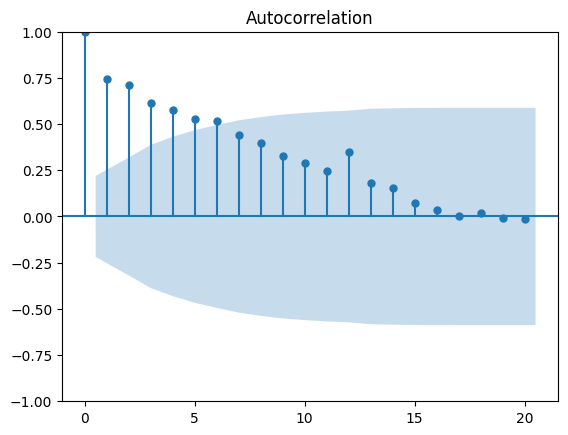

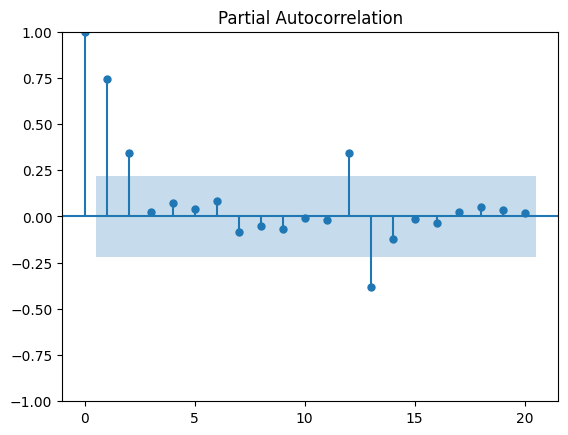

In [124]:
plot_acf(df_retail.ventas_ajustado, lags = 20)
plot_pacf(df_retail.ventas_ajustado, lags = 20)

plt.show()

In [125]:
# Modulo para uso exclusivo aqui
from statsmodels.tsa.seasonal import seasonal_decompose

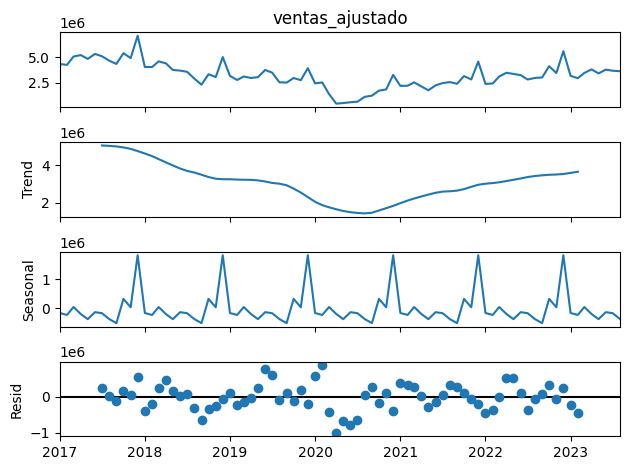

In [126]:
s_dec_additive = seasonal_decompose(df_retail.ventas_ajustado, model = "additive")
s_dec_additive.plot()
plt.show()

In [127]:
residuos = s_dec_additive.resid.dropna()

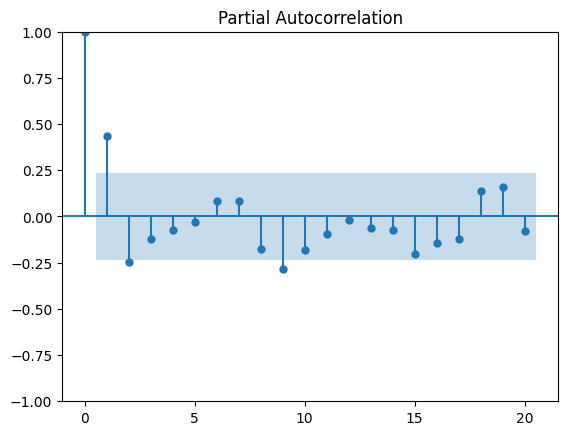

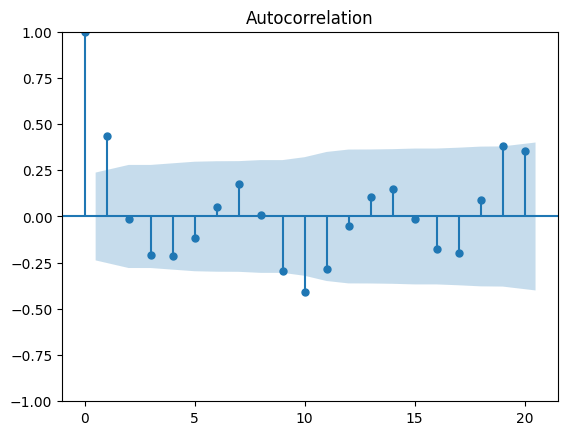

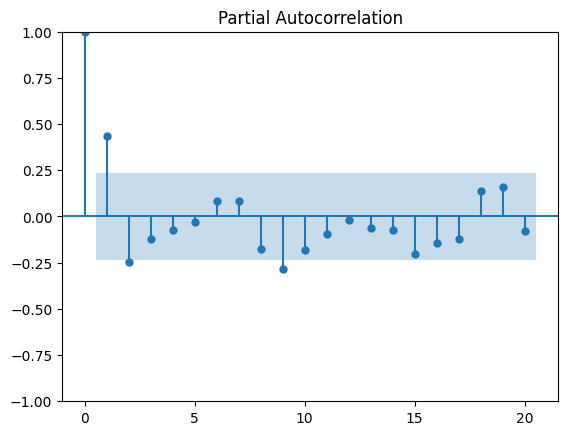

In [128]:
plot_acf(residuos, lags = 20)
plot_pacf(residuos, lags = 20)